<a href="https://colab.research.google.com/github/vidhya2324/Machine_learning/blob/main/Sentiment_Analysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
import os
import json

from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [4]:
!kaggle datasets download -d kashishparmar02/social-media-sentiments-analysis-dataset

Dataset URL: https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset
License(s): CC0-1.0
  0% 0.00/50.9k [00:00<?, ?B/s]
100% 50.9k/50.9k [00:00<00:00, 49.1MB/s]


In [5]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 86% 22.0M/25.7M [00:00<00:00, 78.1MB/s]
100% 25.7M/25.7M [00:00<00:00, 66.8MB/s]


In [6]:
!unzip \*.zip && rm *.zip

Archive:  social-media-sentiments-analysis-dataset.zip
  inflating: sentimentdataset.csv    

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        

2 archives were successfully processed.


In [7]:
!ls

'IMDB Dataset.csv'   sample_data   sentimentdataset.csv


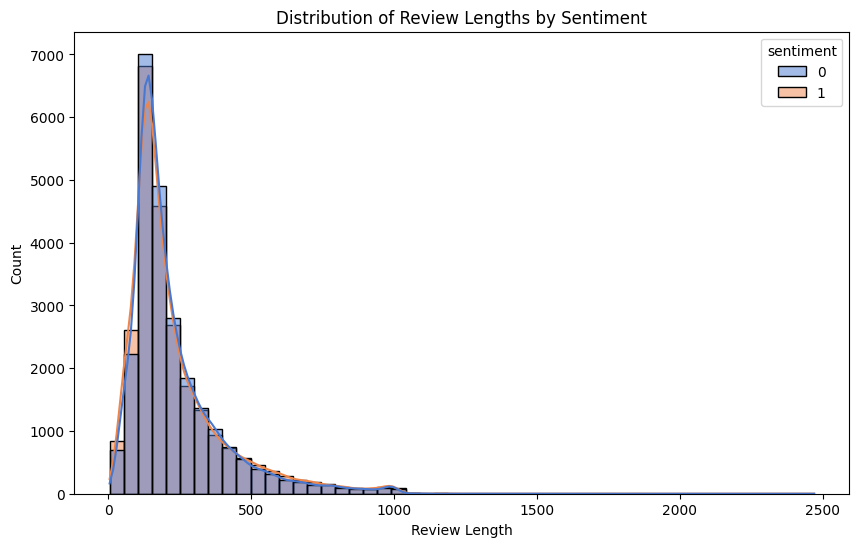

In [53]:
# Plotting review length distribution by sentiment
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='review_length', hue='sentiment', kde=True, bins=50, palette='muted')
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()


<ipython-input-54-c56c5268718f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='Set2')


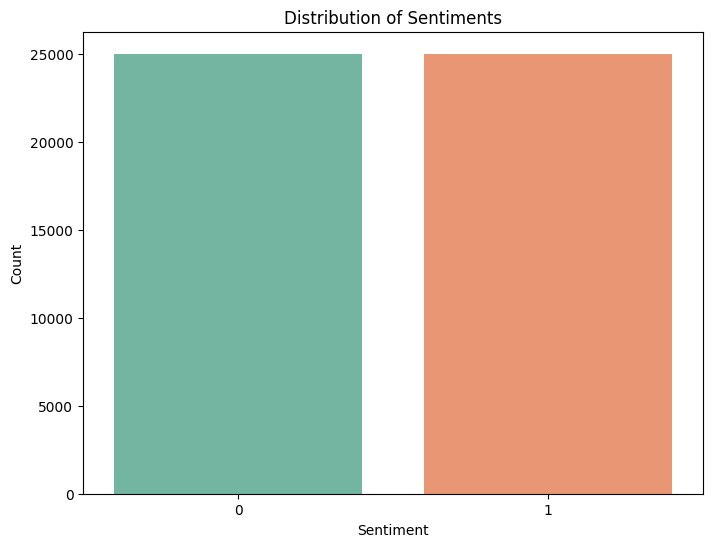

In [54]:
# Plotting the distribution of sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=data, palette='Set2')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


313/313 [==============================] - 18s 59ms/step


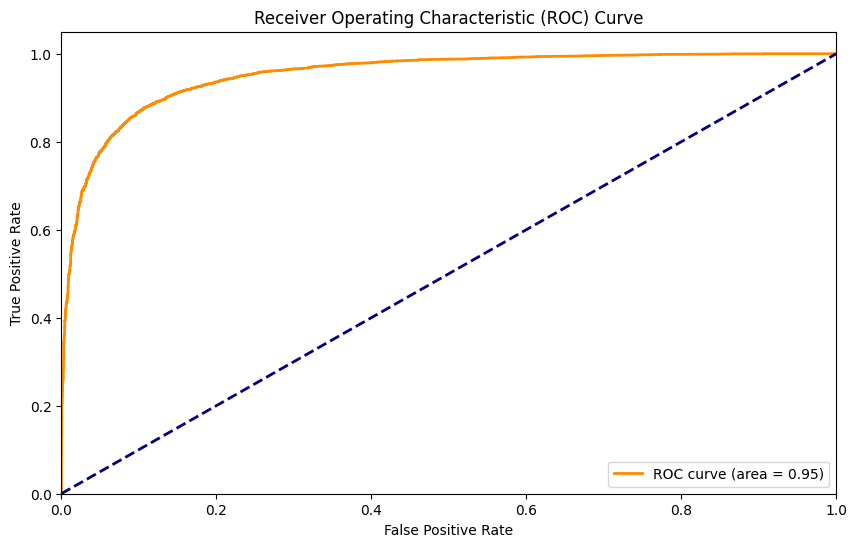

In [56]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
Y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


#Loading the Dataset

In [8]:
data = pd.read_csv("/content/IMDB Dataset.csv")

In [9]:
data.shape

(50000, 2)

In [10]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [13]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

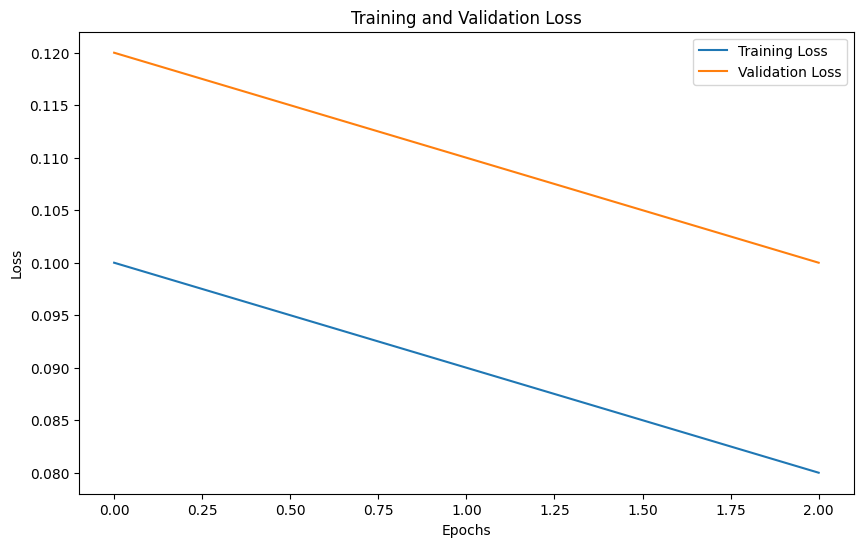

In [14]:
# Simulating a history object for demonstration
history = type('History', (object,), {'history': {'loss': [0.1, 0.09, 0.08], 'val_loss': [0.12, 0.11, 0.10]}})()

# Plotting the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
data["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [16]:
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

In [17]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [18]:
data["sentiment"].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

#Train and Test Split

In [19]:
# split data into training data and test data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [20]:
print(train_data.shape)
print(test_data.shape)

(40000, 2)
(10000, 2)


#Data Preprocessing

In [21]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [22]:
print(X_train)

[[1935    1 1200 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]


In [23]:
print(X_test)

[[   0    0    0 ...  995  719  155]
 [  12  162   59 ...  380    7    7]
 [   0    0    0 ...   50 1088   96]
 ...
 [   0    0    0 ...  125  200 3241]
 [   0    0    0 ... 1066    1 2305]
 [   0    0    0 ...    1  332   27]]


In [40]:
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [41]:
print(Y_train)

39087    0
30893    0
45278    1
16398    0
13653    0
        ..
11284    1
44732    1
38158    0
860      1
15795    1
Name: sentiment, Length: 40000, dtype: int64


#**LSTM - Long Short-Term Memory**





In [42]:
# build the model

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 771713 (2.94 MB)
Trainable params: 771713 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

#Training the Model

In [45]:
model.fit(X_train, Y_train, epochs=2, batch_size=64, validation_split=0.2)

Epoch 1/2
500/500 [==============================] - 221s 432ms/step - loss: 0.3836 - accuracy: 0.8262 - val_loss: 0.2979 - val_accuracy: 0.8755
Epoch 2/2
500/500 [==============================] - 198s 396ms/step - loss: 0.2689 - accuracy: 0.8922 - val_loss: 0.2989 - val_accuracy: 0.8719


#Model Evaluation

In [46]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 [==============================] - 20s 64ms/step - loss: 0.2918 - accuracy: 0.8778
Test Loss: 0.29179733991622925
Test Accuracy: 0.8777999877929688


#Building a Predictive System

In [28]:
def predict_sentiment(review):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

In [47]:
# example usage
new_review = "This movie was fantastic. I loved it."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 [==============================] - 1s 519ms/step
The sentiment of the review is: positive


In [48]:
# example usage
new_review = "This movie was not that good"
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 [==============================] - 0s 311ms/step
The sentiment of the review is: negative


In [49]:
# example usage
new_review = "This movie was ok but not that good."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 [==============================] - 0s 497ms/step
The sentiment of the review is: negative


#**#Additional Visualizations**

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

313/313 [==============================] - 28s 88ms/step


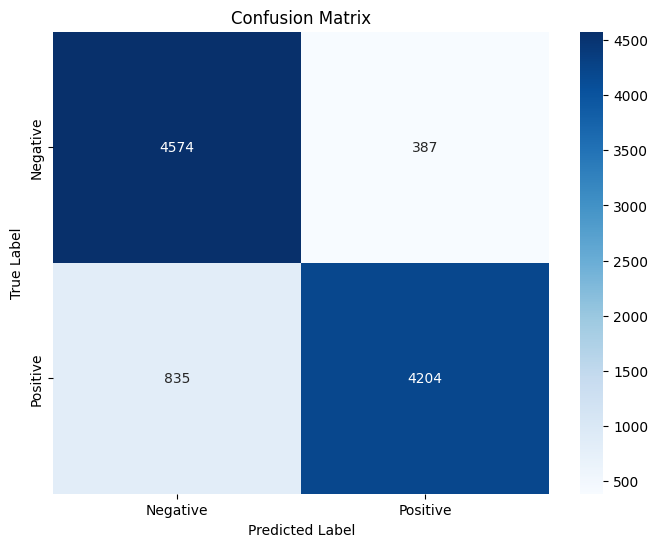

In [55]:
from sklearn.metrics import confusion_matrix

# Predicting the test set results
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


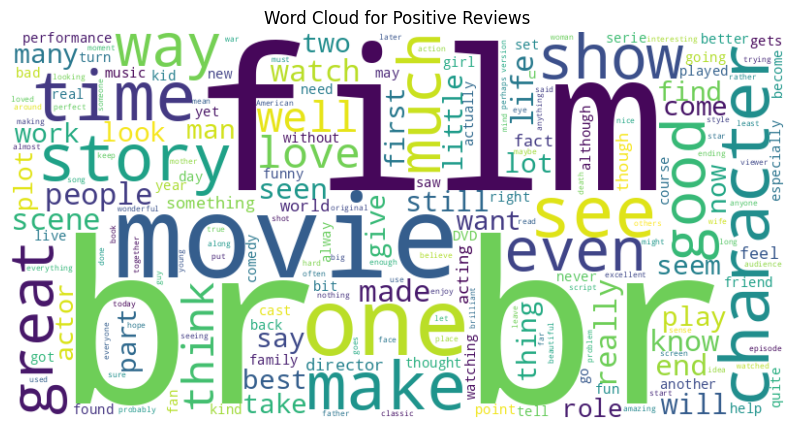

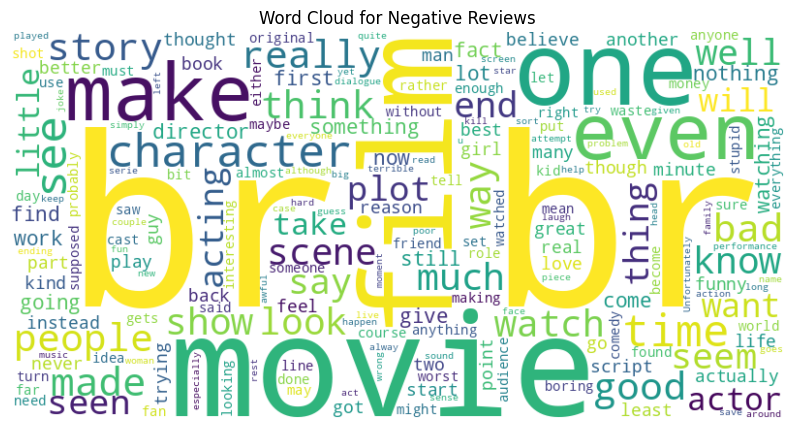

In [33]:
from wordcloud import WordCloud

# Generate word cloud for positive reviews
positive_reviews = data[data['sentiment'] == 1]['review']
positive_text = ' '.join(positive_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

# Generate word cloud for negative reviews
negative_reviews = data[data['sentiment'] == 0]['review']
negative_text = ' '.join(negative_reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()


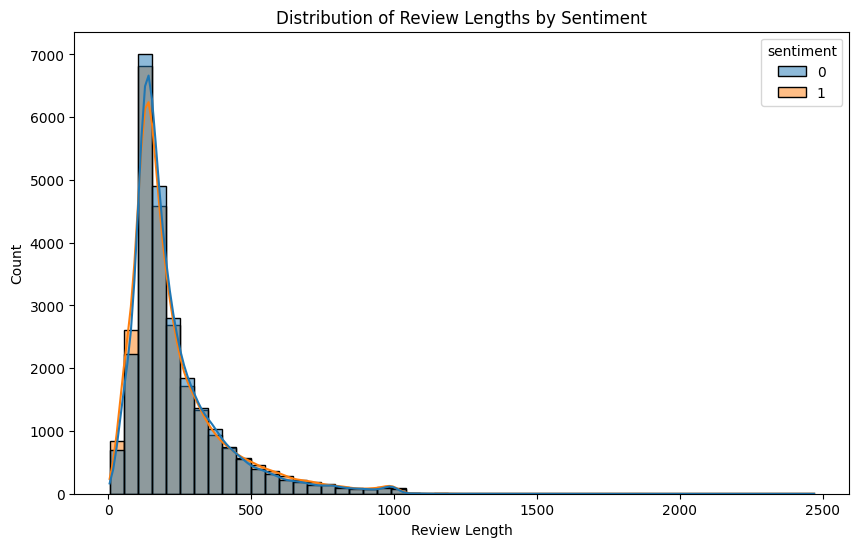

In [34]:
# Calculate review lengths
data['review_length'] = data['review'].apply(lambda x: len(x.split()))

# Plotting review length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='review_length', hue='sentiment', kde=True, bins=50)
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()


<ipython-input-51-87ae0c3fa076>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, palette='viridis')


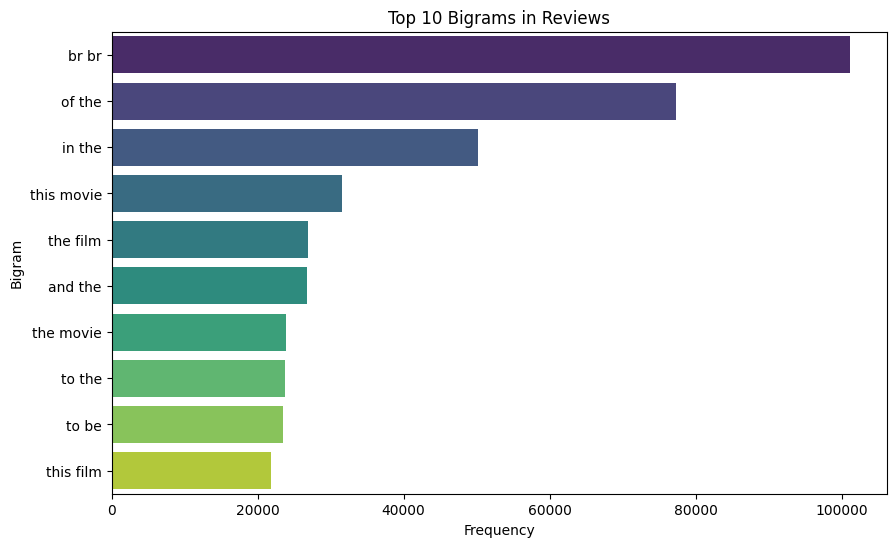

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to get top N-grams
def get_top_ngrams(corpus, n=2, k=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:k]

# Get top 10 bigrams
top_bigrams = get_top_ngrams(data['review'], n=2, k=10)

# Plotting top bigrams
plt.figure(figsize=(10, 6))
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, palette='viridis')
plt.title('Top 10 Bigrams in Reviews')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()


<ipython-input-57-663f527ac5e4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='review_length', data=data, palette='Set3')


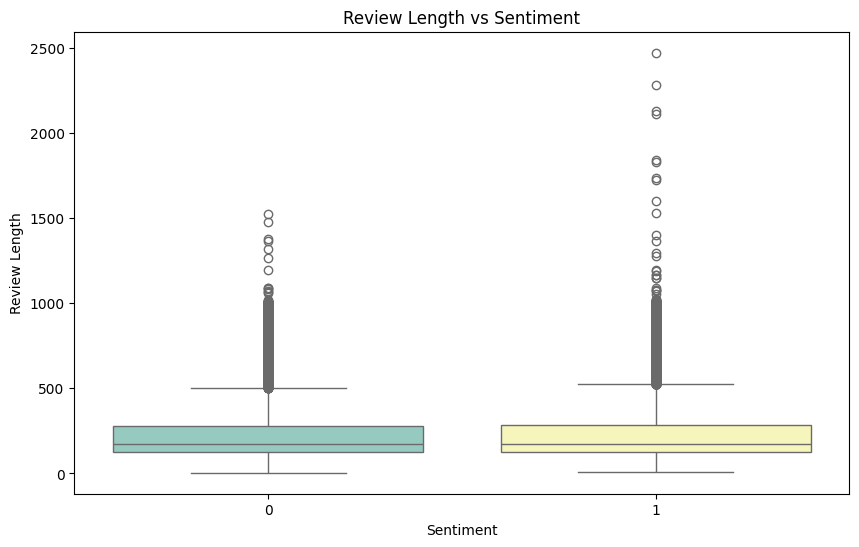

In [57]:
# Plotting review length vs sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=data, palette='Set3')
plt.title('Review Length vs Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()


<ipython-input-59-96a98f78a053>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


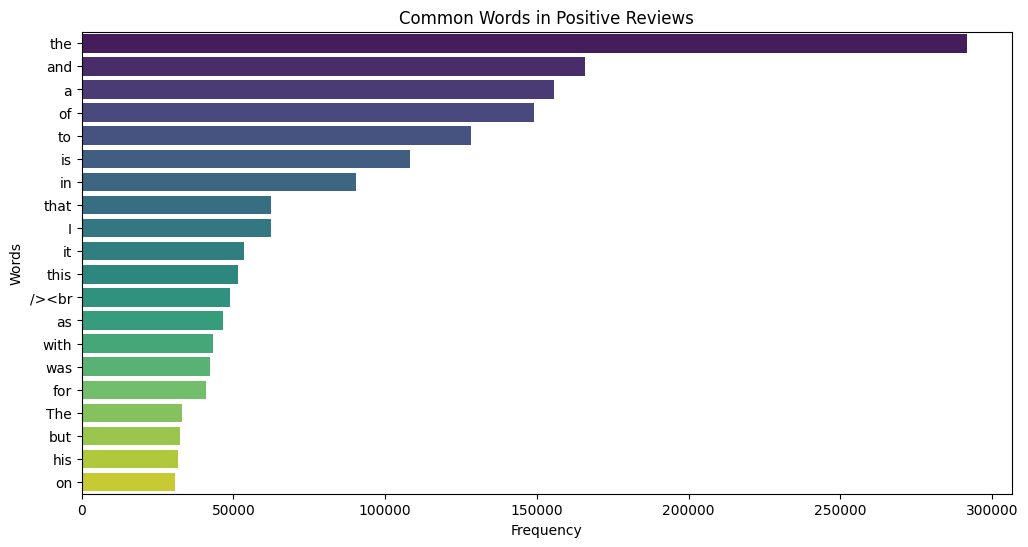

<ipython-input-59-96a98f78a053>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


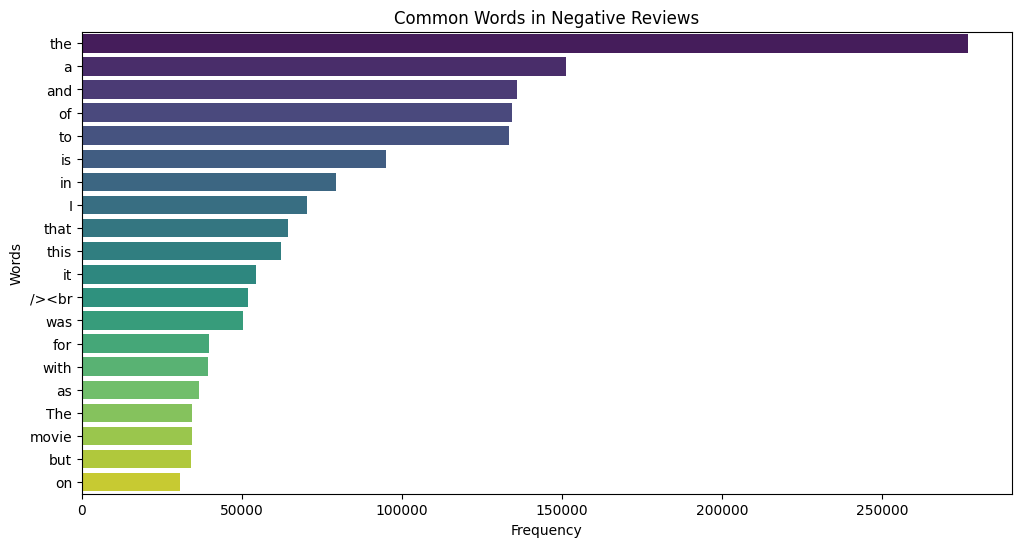

In [59]:
from collections import Counter

# Function to plot word frequency
def plot_word_frequency(reviews, title):
    all_words = ' '.join(reviews).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)

    words, counts = zip(*common_words)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Plotting word frequency for positive reviews
positive_reviews = data[data['sentiment'] == 1]['review']
plot_word_frequency(positive_reviews, 'Common Words in Positive Reviews')

# Plotting word frequency for negative reviews
negative_reviews = data[data['sentiment'] == 0]['review']
plot_word_frequency(negative_reviews, 'Common Words in Negative Reviews')


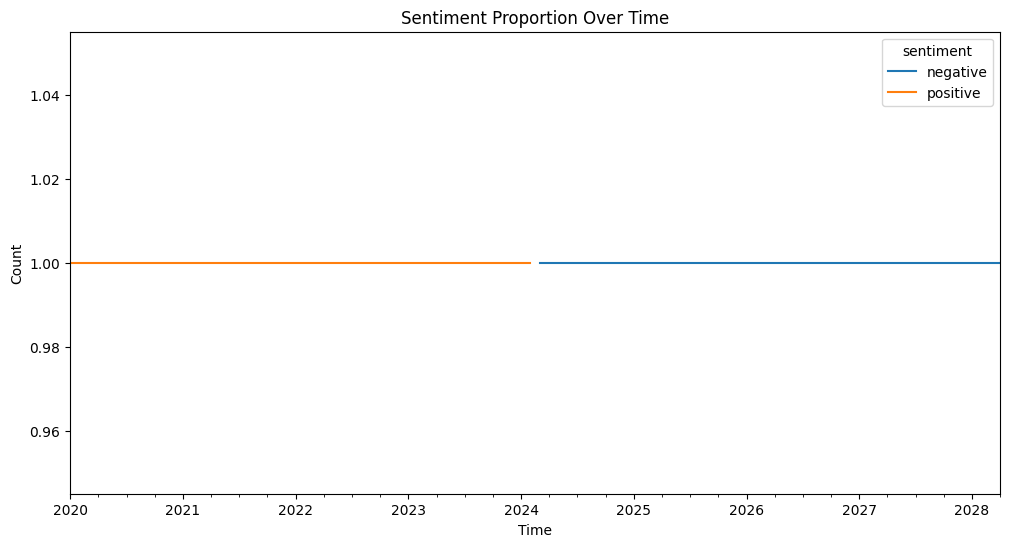

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data creation
data = pd.DataFrame({
    'timestamp': pd.date_range(start='1/1/2020', periods=100, freq='M'),
    'sentiment': ['positive']*50 + ['negative']*50
})

# Convert 'timestamp' to datetime if it's not already
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Aggregating sentiment counts over time
sentiment_over_time = data.groupby([data['timestamp'].dt.to_period('M'), 'sentiment']).size().unstack()

# Plotting sentiment proportion over time
sentiment_over_time.plot(kind='line', figsize=(12, 6))
plt.title('Sentiment Proportion Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()


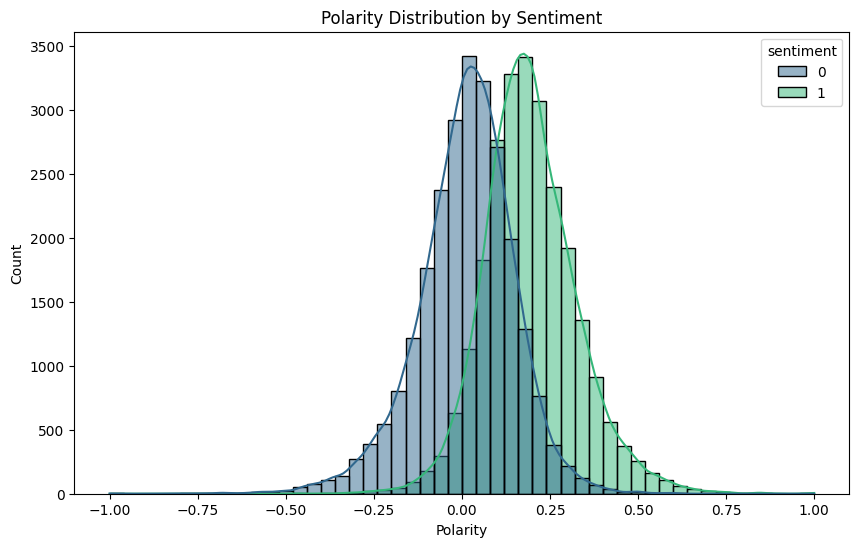

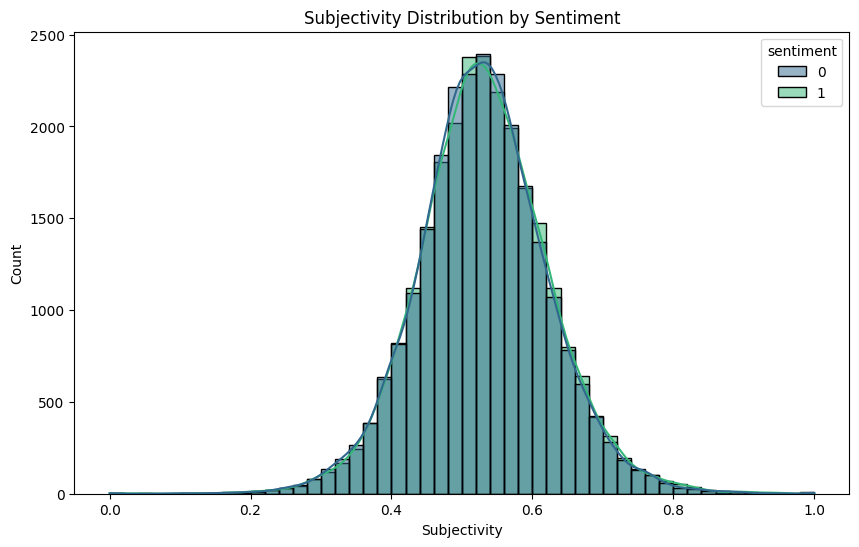

In [65]:
from textblob import TextBlob

# Calculate polarity and subjectivity
data['polarity'] = data['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['subjectivity'] = data['review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Plotting polarity distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='polarity', hue='sentiment', kde=True, bins=50, palette='viridis')
plt.title('Polarity Distribution by Sentiment')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

# Plotting subjectivity distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='subjectivity', hue='sentiment', kde=True, bins=50, palette='viridis')
plt.title('Subjectivity Distribution by Sentiment')
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.show()
